# DILI optimization with ReLeaSE algorithm

In this experiment we will optimized parameters of pretrained generative RNN to produce molecules with values of DILI within drug-like region according to Lipinsky rule. We use policy gradient algorithm with custom reward function to bias the properties of generated molecules aka Reinforcement Learning for Structural Evolution (ReLeaSE) as was proposed in **Popova, M., Isayev, O., & Tropsha, A. (2018). *Deep reinforcement learning for de novo drug design*. Science advances, 4(7), eaap7885.** 

## Imports

In [1]:
import torch
print(torch.cuda.is_available())

/hpc/group/rekerlab/byz6/miniconda3/envs/generative_models/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [1]:
%env CUDA_VISIBLE_DEVICES=1
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./release/')
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F
use_cuda = torch.cuda.is_available()
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData 
from utils import canonical_smiles
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

env: CUDA_VISIBLE_DEVICES=1


/hpc/group/rekerlab/byz6/miniconda3/envs/generative_models/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting up the generator

### Loading data for the generator

In [2]:
gen_data_path = './data/chembl_22_clean_1576904_sorted_std_final.smi'

In [3]:
#Chembl
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

In [4]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

## Util functions

**plot_hist** function plots histogram of predicted properties and a vertical line for thershold.

In [5]:
def plot_hist(prediction, n_to_generate):
    prediction = np.array(prediction)
    percentage_in_threshold = np.sum((prediction >= 0.5) & 
                                     (prediction <= 1.0))/len(prediction)
    print("Percentage of predictions within similarity region:", percentage_in_threshold)
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    plt.axvline(x=0.5)
    plt.axvline(x=1.0)
    ax.set(xlabel='Predicted Similarity', 
           title='Distribution of predicted Similarity for generated molecules')
    plt.show()

**estimate_and_update** function:

1) generates n_to_generate number of SMILES strings

2) filters invalid SMILES

3) predicts logP for valid SMILES

4) plots histogram of predicted logP

5) Returns valid SMILES and their predicted logPs

In [6]:
def estimate_and_update(generator, predictor, drug, n_to_generate):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=100)[1:-1])

#     sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
#     unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(generated, drug, use_tqdm=True)  
    print(len(prediction))
                                                       
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction

## Initializing and training the generator

We will used stack augmented generative GRU as a generator. The model was trained to predict the next symbol from SMILES alphabet using the already generated prefix. Model was trained to minimize the cross-entropy loss between predicted symbol and ground truth symbol. Scheme of the generator when inferring new SMILES is shown below:

<img src="./figures/generator.png">

Initialize stack-augmented generative RNN:

In [7]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

If you want train the model from scratch, uncomment the lines below:

In [8]:
model_path = './trainedModels/generator/Chemblrnn'

In [9]:
losses = my_generator.fit(gen_data,1000)

Training in progress...:  10%|█▌             | 100/1000 [00:55<08:59,  1.67it/s]

 55s (100 10%) 2.6244]
<nP12I
(S)-0C6/8s)#B4N])]5sI> 



Training in progress...:  20%|███            | 200/1000 [01:52<08:12,  1.63it/s]

 52s (200 20%) 2.1366]
<s]49H#2]=8
)7A8<=-%l4)A#/Nl.o(nler+\+i6I
%\2<7lO\-P/c%Oc(3\IO0BS/p1B8ccccc(ciIH3iCO6C4=> 



Training in progress...:  30%|████▍          | 299/1000 [02:42<06:12,  1.88it/s]

 43s (300 30%) 2.2014]


Training in progress...:  30%|████▌          | 300/1000 [02:43<06:43,  1.73it/s]

<CF/80I
.34OC2(Ns=O)%NCC(7)1Cc1CcCCCCCCC(C)C))CNC(=1=(2H%)2)Occ(NO)OC(cccN=O)cccccccc2c1)Nccc(1)C))r) 



Training in progress...:  40%|█████▉         | 399/1000 [03:35<04:04,  2.46it/s]

 36s (400 40%) 1.7794]


Training in progress...:  40%|██████         | 400/1000 [03:36<05:09,  1.94it/s]

<Prr5OI0CC(CCC(=CC=(=CC)CCCCOc2Ccc1ccc
c1NccOC(OCCOp1n)c2Oc11)CCNO1)O=Oc(())nc2N[l/IA3I2l9o-/5n1)=@\5 



Training in progress...:  50%|███████▍       | 499/1000 [04:31<04:44,  1.76it/s]

 32s (500 50%) 1.6873]


Training in progress...:  50%|███████▌       | 500/1000 [04:32<05:16,  1.58it/s]

<C]rCC(=O)C(N(CCC(C)C)C(#(COcC12Oc(CCCCC1)NCCH=O))C31cc3(=O)1c2cc2)Nn(OC)c1ccc1nCc1(=O)c(=O)c(2cc1CN( 



Training in progress...:  60%|█████████      | 600/1000 [05:28<03:55,  1.70it/s]

 28s (600 60%) 1.9594]
<(CC7o0O)F.=c2c()N=N(CC1Cc> 



Training in progress...:  70%|██████████▌    | 700/1000 [06:27<03:20,  1.50it/s]

 27s (700 70%) 1.7755]
<14C(OO)N=O)c1n@c1(O))(CC(=O)(O)ccc1c(S)1(=O)1cccc(cc(2CC22> 



Training in progress...:  80%|███████████▉   | 799/1000 [07:18<01:40,  2.00it/s]

 18s (800 80%) 1.6090]
<C1OC(==O)2C(=O)c1()+N)CO(=O)c1cccccccc(ncc32)C)(=O)c11ccc(CC)(C1c(CO2)ccccc(C)C(O)1(C1CCCCNs)ccc1c(c 



Training in progress...:  90%|█████████████▍ | 899/1000 [08:13<00:57,  1.75it/s]

 14s (900 90%) 1.9059]


Training in progress...:  90%|█████████████▌ | 900/1000 [08:14<00:58,  1.70it/s]

<On552HnPcc1F)#c1cc)c1-ccc(c1C(8NCOC1=OC)1)(cc1cccccccc)C(C=CnHO2cccc((O)3cCccc(OC=O)NCCC(=Occc1)cccc 



Training in progress...: 100%|██████████████| 1000/1000 [09:09<00:00,  1.82it/s]

 9s (1000 100%) 1.6686]
<-+lC(=O)N(CClCCC(1)Ccccccc(3cc2c(c3c1ccccccncc(n> 



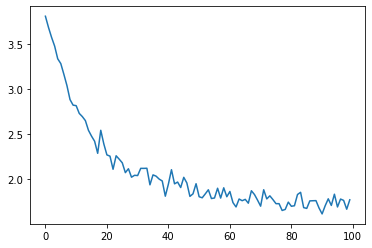

In [10]:
plt.plot(losses)

In [15]:
my_generator.evaluate(gen_data)

'<CCC1)nc2cC((n=O)Ccccncc3c2c12]N(>'

In [12]:
my_generator.save_model(model_path)

Alternatively, you can skip the process of training and load the pretrained parameters into the model:

In [13]:
my_generator.load_model(model_path)

## Setting up the predictor

For this demo we will use Recurrent Neural Network, i.e. unidirectional LSTM with 2 layers. The network is trained in 5-fold cross validation manner using the OpenChem toolkit (https://github.com/Mariewelt/OpenChem). In this demo we only upload the pretrained model. The training demo is in *RecurrentQSAR-example-logp.ipynb* file in the same directory. 

In [16]:
#tanimoto sim 
from SimilarityCalculatorSMILES import SimilarityCalculatorSMILES
my_predictor = SimilarityCalculatorSMILES(tokens)

In [25]:
selfies = ['CC','CC1(C)OOC(C)(C)OOC(C)(C)OO1','COOOO']
drug = ''

In [26]:
mol, pred, invalid = my_predictor.predict(selfies, drug)

In [27]:
pred

[0.1111111111111111, 1.0, 0.05555555555555555]

Here we produce the unbiased distribution of the property:

Generating molecules...: 100%|██████████████| 1000/1000 [01:14<00:00, 13.37it/s]
[15:49:52] SMILES Parse Error: syntax error while parsing: C(C)C2=CC1cCC(=O)(1)CON2Nccc(C)NC(C1)C1C1OCC%NOCCC(C=O3)c1Nc(23)NC)c(=O)c1ccc2c1
[15:49:52] SMILES Parse Error: Failed parsing SMILES 'C(C)C2=CC1cCC(=O)(1)CON2Nccc(C)NC(C1)C1C1OCC%NOCCC(C=O3)c1Nc(23)NC)c(=O)c1ccc2c1' for input: 'C(C)C2=CC1cCC(=O)(1)CON2Nccc(C)NC(C1)C1C1OCC%NOCCC(C=O3)c1Nc(23)NC)c(=O)c1ccc2c1'
[15:49:52] SMILES Parse Error: syntax error while parsing: CCCC(CCC=O3c(c2)ccc1Ocn(CN3(CC)OCCCCCC(=O)c12)cn1cc2c(CC(CC1)(=C)NC2)c()=-OCCCCCCOC(=O)C)(=NC)Occ(C
[15:49:52] SMILES Parse Error: Failed parsing SMILES 'CCCC(CCC=O3c(c2)ccc1Ocn(CN3(CC)OCCCCCC(=O)c12)cn1cc2c(CC(CC1)(=C)NC2)c()=-OCCCCCCOC(=O)C)(=NC)Occ(C' for input: 'CCCC(CCC=O3c(c2)ccc1Ocn(CN3(CC)OCCCCCC(=O)c12)cn1cc2c(CC(CC1)(=C)NC2)c()=-OCCCCCCOC(=O)C)(=NC)Occ(C'
[15:49:52] SMILES Parse Error: syntax error while parsing: p@3([lS0-Snc1cc9-3c4(Cc2cn21ccccc2cCc(CCC(=O)Cc1cc(C)N(c1)ccc(C

[15:49:52] SMILES Parse Error: syntax error while parsing: C1CCsc1CN(=)-(c1C)Cc2nn1C(=O)1c1ccc1
[15:49:52] SMILES Parse Error: Failed parsing SMILES 'C1CCsc1CN(=)-(c1C)Cc2nn1C(=O)1c1ccc1' for input: 'C1CCsc1CN(=)-(c1C)Cc2nn1C(=O)1c1ccc1'
[15:49:52] SMILES Parse Error: unclosed ring for input: 'CCO2Clc1cc1'
[15:49:52] SMILES Parse Error: extra open parentheses for input: 'CCCccc3(C(c1cccc1'
[15:49:52] SMILES Parse Error: syntax error while parsing: 6CC1ncCSCNC1C=O)C(2C1cc()c
cccc2
[15:49:52] SMILES Parse Error: Failed parsing SMILES '6CC1ncCSCNC1C=O)C(2C1cc()c
cccc2' for input: '6CC1ncCSCNC1C=O)C(2C1cc()c
cccc2'
[15:49:52] SMILES Parse Error: syntax error while parsing: ccccc1/Cn(c1(Cccc1)CC2CO)NC(Cc1cccc1)c1CN(CCCCC(=Oicc2
[15:49:52] SMILES Parse Error: Failed parsing SMILES 'ccccc1/Cn(c1(Cccc1)CC2CO)NC(Cc1cccc1)c1CN(CCCCC(=Oicc2' for input: 'ccccc1/Cn(c1(Cccc1)CC2CO)NC(Cc1cccc1)c1CN(CCCCC(=Oicc2'
[15:49:52] SMILES Parse Error: unclosed ring for input: 'C1c1Sccc1cc20OC1(C=S)1'
[15:49:5

42
Percentage of predictions within similarity region: 0.0
Proportion of valid SMILES: 0.042


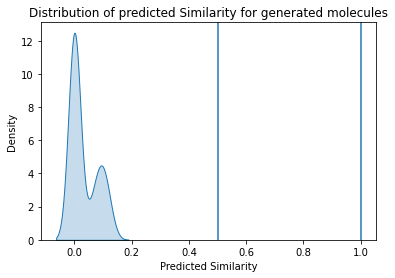

In [28]:
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           drug,
                                                           n_to_generate=1000)

## Biasing the distribution of the generator with reinforcement learning (policy gradient)

We combine the generator and the predictor into a single pipeline. The generator produces new SMILES string, which is then evaluated by the predictor. Based on the obtain prediction and our goal, we assign a numerical reward value and update the parameters of the generator using policy gradient algorithm.

<img src="./figures/rl_pipeline.png">

Policy gradient loss is defined as:
$$
L(S|\theta) = -\dfrac{1}{n}\sum_{i=1}^{|S|} \sum_{j=1}^{length(s_i)} R_i\cdot \gamma^i \cdot \log p(s_i|s_0 \dots s_{i-1}\theta),
$$

where $R_i$ is the reward obtained at time step $i$ $\gamma$ is the discount factor and $p(s_i|s_0 \dots s_{i-1}, \theta)$ is the probability of the next character given the prefix, which we obtain from the generator. 

In our case the reward is the same for every time step and is equal to the reward for the whole molecule. Discount factor $\gamma$ is a number close to $1.0$ (it could be $1.0$).

### Optimizing logP to be in drug like region

In [137]:
from reinforcement import Reinforcement

Making a copy of the generator that will be optimized

In [138]:
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)

my_generator_max.load_model(model_path)

In [139]:
# Setting up some parameters for the experiment
n_to_generate = 200
n_policy_replay = 10
n_policy = 20
n_iterations = 100

In [140]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [141]:
def get_reward_logp(smiles, predictor, invalid_reward=0.0):
    drug = ''
    mol, prop, nan_smiles = predictor.predict([smiles],drug)
    if len(nan_smiles) == 1:
        return invalid_reward
    reward = 10*(np.tanh((3*prop[0]) - 1))
    return reward

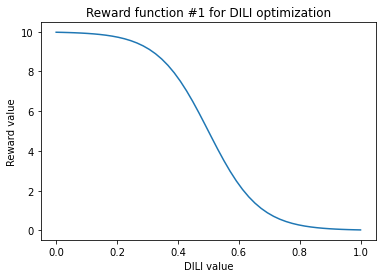

In [142]:
x = np.linspace(0, 1)
reward = lambda x: 10*(np.tanh((3*x)-1))
plt.plot(x, [reward(i) for i in x])
plt.xlabel('Similarity value')
plt.ylabel('Reward value')
plt.title('Reward function for Similarity optimization')
plt.show()

In [143]:
RL_logp = Reinforcement(my_generator_max, my_predictor, get_reward_logp)

In [144]:
rewards = []
rl_losses = []

Policy gradient...:   0%|                                | 0/15 [00:00<?, ?it/s]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 1616.93it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5645.09it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14665.40it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 6990.51it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8719.97it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.95it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14169.95it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15420.24it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16777.22it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14122.24it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13066.37it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 5203.85it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3640.89it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.84it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13530.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13357.66it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.08it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12192.74it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:   7%|█▌                      | 1/15 [00:07<01:47,  7.68s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13273.11it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15252.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 2642.91it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9020.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13981.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.21it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.17it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14665.40it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16513.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4760.84it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2953.74it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13107.20it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13189.64it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15477.14it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14364.05it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5256.02it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.14it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15947.92it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7281.78it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.16it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9776.93it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.90it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  13%|███▏                    | 2/15 [00:15<01:37,  7.53s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14926.35it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16844.59it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.21it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.25it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14364.05it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13573.80it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14027.77it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1081.56it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.40it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.32it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 16644.06it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 18315.74it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.40it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.30it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14315.03it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16008.79it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.18it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14074.85it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16844.59it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.36it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.20it/s]
[12:22:31] Explicit valence for atom # 54 Br, 5, is greater than permitted


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



0it [00:00, ?it/s]

0it [00:00, ?it/s]


Validating SMILES
Test size = 0
Elapsed time = 0:00:00
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 5329.48it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6875.91it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15141.89it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.25it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12052.60it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.29it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.33it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  20%|████▊                   | 3/15 [00:22<01:29,  7.46s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12336.19it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12372.58it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 1691.93it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.82it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12018.06it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.17it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15307.68it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4837.72it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11650.84it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15477.14it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.93it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.89it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14217.98it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15087.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.20it/s]
[12:22:39] Explicit valence for atom # 51 Br, 5, is greater than permitted


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



0it [00:00, ?it/s]

0it [00:00, ?it/s]


Validating SMILES
Test size = 0
Elapsed time = 0:00:00
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12446.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.40it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.32it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10591.68it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12905.55it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.14it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.15it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14614.30it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  27%|██████▍                 | 4/15 [00:29<01:22,  7.47s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13357.66it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14074.85it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.90it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14315.03it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15307.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.15it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 16578.28it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 18396.07it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.34it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.21it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10280.16it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.14it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15887.52it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.03it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 16448.25it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17050.02it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.28it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.22it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11066.77it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12087.33it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.26it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14768.68it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.25it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14768.68it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15768.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.66it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  33%|████████                | 5/15 [00:37<01:14,  7.43s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11305.40it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14413.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.20it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.18it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14463.12it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11781.75it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.25it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14413.42it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13573.80it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15252.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.28it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.20it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14614.30it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.25it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.15it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11915.64it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 16578.28it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.37it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.16it/s]
[12:22:54] Explicit valence for atom # 58 Br, 3, is greater than permitted


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



0it [00:00, ?it/s]

0it [00:00, ?it/s]


Validating SMILES
Test size = 0
Elapsed time = 0:00:00
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13706.88it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7839.82it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.98it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14315.03it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  40%|█████████▌              | 6/15 [00:44<01:06,  7.43s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13751.82it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13706.88it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.53it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14266.34it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14820.86it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15947.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.21it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14979.66it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.29it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.25it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13443.28it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.14it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11650.84it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14820.86it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12865.96it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16008.79it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.81it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 5729.92it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.33it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 5504.34it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  47%|███████████▏            | 7/15 [00:52<00:59,  7.48s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11155.06it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.80it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12865.96it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 16070.13it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6472.69it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11983.73it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4332.96it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.81it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14413.42it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15033.35it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.27it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.21it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13981.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.42it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.29it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14926.35it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.08it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.22it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13315.25it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.15it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13148.29it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15252.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.40it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.28it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15420.24it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  53%|████████████▊           | 8/15 [00:59<00:52,  7.45s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11949.58it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12710.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15033.35it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.84it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14979.66it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.15it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9404.27it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13443.28it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 16008.79it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15947.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.28it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.33it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 16008.79it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.42it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.32it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 16513.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11491.24it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.22it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12087.33it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.26it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.32it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.33it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14768.68it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.48it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.27it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  60%|██████████████▍         | 9/15 [01:06<00:44,  7.35s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14716.86it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15947.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15307.68it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.20it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.19it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12945.38it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.38it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.20it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14217.98it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.18it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14217.98it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16777.22it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9157.87it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.27it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.30it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13573.80it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 16070.13it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.39it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.31it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15141.89it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15307.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14513.16it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15947.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  67%|███████████████▎       | 10/15 [01:14<00:36,  7.33s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11683.30it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13981.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4826.59it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4144.57it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.90it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13981.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15947.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9279.43it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 10565.00it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.35it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.27it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 16194.22it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.20it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7584.64it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8305.55it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.27it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15592.21it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17697.49it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.23it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 8256.50it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4328.49it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13751.82it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.90it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.89it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14614.30it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  73%|████████████████▊      | 11/15 [01:21<00:29,  7.32s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15768.06it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13934.56it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1734.62it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.98it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 1646.12it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4319.57it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.83it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13357.66it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15252.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.27it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.33it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 5518.82it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5801.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.96it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13751.82it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.17it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14315.03it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.22it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10951.19it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5737.76it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 16513.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15363.75it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14820.86it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.32it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  80%|██████████████████▍    | 12/15 [01:28<00:22,  7.35s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15768.06it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17697.49it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.17it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15947.92it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.31it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.20it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 8128.50it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8224.13it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.79it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12520.31it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.06it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9177.91it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2565.32it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.78it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7157.52it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2718.28it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4165.15it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14122.24it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16256.99it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.80it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15887.52it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.75it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15947.92it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2489.20it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.23it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  87%|███████████████████▉   | 13/15 [01:36<00:14,  7.42s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14563.56it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.35it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.20it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14169.95it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.96it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12905.55it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15768.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.20it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.16it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 1446.81it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4476.31it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11781.75it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.84it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14463.12it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15033.35it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 18078.90it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.18it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.20it/s]
[12:23:52] Explicit valence for atom # 51 Br, 4, is greater than permitted


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



0it [00:00, ?it/s]

0it [00:00, ?it/s]


Validating SMILES
Test size = 0
Elapsed time = 0:00:00
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15033.35it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.20it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.28it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10356.31it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.14it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 8473.34it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.90it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  93%|█████████████████████▍ | 14/15 [01:43<00:07,  7.46s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13842.59it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12157.40it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.97it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14266.34it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.83it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10280.16it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.20it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14979.66it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.06it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12710.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16008.79it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13617.87it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.98it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14266.34it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.19it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11366.68it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3287.07it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.98it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 5924.16it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6700.17it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.77it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...: 100%|███████████████████████| 15/15 [01:51<00:00,  7.44s/it]


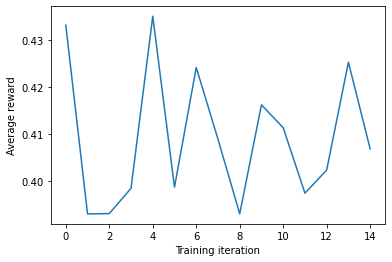

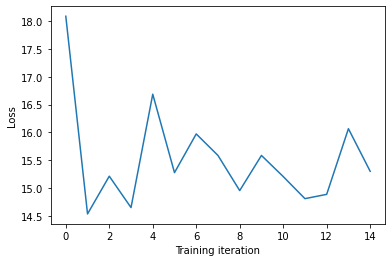

Generating molecules...: 100%|████████████████| 200/200 [00:03<00:00, 52.77it/s]
[12:24:07] Explicit valence for atom # 57 Br, 3, is greater than permitted


Setting molecule featurization parameters to default.
Loading data


199it [00:00, 250876.61it/s]
100%|█████████████████████████████████████| 199/199 [00:00<00:00, 252165.10it/s]


Validating SMILES
Test size = 199


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]

Saving predictions to None
Elapsed time = 0:00:02
199
Percentage of predictions within drug-like region: 0.0
Proportion of valid SMILES: 0.995


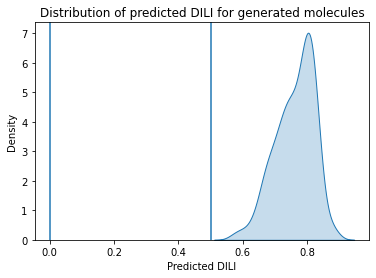

Sample trajectories:
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)OC#N
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)OC(\C)OC(C)OC=O
C1C(C2=NC(=CS2)C3=CC=C(C=C3)C#N)C(CN4C=[N+1](C=N4)C(C)OC(=O)N(C)C5=C(C=CC=N5)COC(=O)CNC)(C6=C(C=CC(=C6)F)F)O1
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)OCCCNOC=[C@@H1]CC=CCN=CCC
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)OC=CC=CC=CCC=CC=CN(Br)[N+1]


Policy gradient...:   0%|                                | 0/15 [00:00<?, ?it/s]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10866.07it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12264.05it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.42it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.92it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15307.68it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15252.01it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6278.90it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13934.56it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5329.48it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.84it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 6204.59it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7371.36it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13107.20it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3153.61it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13706.88it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2175.47it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.54it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 1397.17it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2187.95it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15947.92it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15650.39it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5391.14it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.16it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:   7%|█▌                      | 1/15 [00:08<01:52,  8.05s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15534.46it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5309.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.18it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11618.57it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14614.30it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11244.78it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13573.80it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13231.24it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.23it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11335.96it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.41it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14074.85it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.78it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14513.16it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.15it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15650.39it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.18it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13315.25it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15768.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 8456.26it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.81it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  13%|███▏                    | 2/15 [00:15<01:41,  7.77s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14979.66it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6978.88it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4766.25it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5667.98it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.97it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4387.35it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2543.54it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 2365.65it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.38it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12446.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 1536.38it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4215.38it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4733.98it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4593.98it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.15it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7570.95it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 9137.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.32it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.21it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15363.75it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13888.42it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 18078.90it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.71it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  20%|████▊                   | 3/15 [00:23<01:33,  7.77s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11459.85it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.93it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.89it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11949.58it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15534.46it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.08it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9799.78it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4419.71it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13107.20it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16008.79it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.30it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.19it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14315.03it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14266.34it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8738.13it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13443.28it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5562.74it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.96it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13315.25it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.39it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.24it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14027.77it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.22it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15363.75it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.29it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.18it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  27%|██████▍                 | 4/15 [00:30<01:24,  7.65s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13530.01it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3292.23it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.14it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10672.53it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15534.46it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17050.02it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14266.34it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.90it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14027.77it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14122.24it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.98it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13573.80it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.71it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4025.24it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4809.98it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.08it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12018.06it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4554.08it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.80it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.89it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14364.05it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1360.46it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.84it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  33%|████████                | 5/15 [00:38<01:16,  7.65s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 16194.22it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.14it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15196.75it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17403.75it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.20it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14926.35it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16844.59it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.29it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.16it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13662.23it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14413.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.89it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15252.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.14it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15477.14it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.14it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 6442.86it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6732.43it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.17it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 6260.16it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.77it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12372.58it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.23it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12018.06it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.98it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  40%|█████████▌              | 6/15 [00:46<01:08,  7.60s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12710.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.03it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 2993.79it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.21it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13573.80it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13400.33it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6678.83it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.78it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 6678.83it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3844.46it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14364.05it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9822.73it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13934.56it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.85it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10155.70it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14926.35it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16256.99it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  47%|███████████▏            | 7/15 [00:53<01:00,  7.57s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14614.30it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 8490.49it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 9664.29it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13797.05it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15477.14it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13273.11it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13231.24it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11983.73it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15947.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.22it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.16it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13934.56it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12520.31it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.33it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11848.32it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14873.42it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15768.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12633.45it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.32it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.18it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  53%|████████████▊           | 8/15 [01:00<00:52,  7.50s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13751.82it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.08it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13443.28it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15477.14it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15141.89it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 16131.94it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 18001.30it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14364.05it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13107.20it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10618.49it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2519.10it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14074.85it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13888.42it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.08it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13934.56it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14873.42it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.81it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  60%|██████████████▍         | 9/15 [01:08<00:45,  7.55s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14665.40it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13662.23it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4712.70it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7767.23it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14027.77it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10866.07it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.83it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12520.31it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 11949.58it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12052.60it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2029.17it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14768.68it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.19it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.14it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12787.51it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5140.08it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9320.68it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15087.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.98it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  67%|███████████████▎       | 10/15 [01:16<00:38,  7.62s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14074.85it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4076.10it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.85it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14315.03it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.28it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.26it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12336.19it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13888.42it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12787.51it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4369.07it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.16it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9868.95it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1430.04it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.85it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7724.32it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.18it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.14it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13486.51it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.06it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4219.62it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4262.50it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.19it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4510.00it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2752.17it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  73%|████████████████▊      | 11/15 [01:24<00:30,  7.64s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12520.31it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 6195.43it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5592.41it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 1635.21it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2528.21it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.03it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11781.75it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.95it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14027.77it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.15it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 3310.42it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3279.36it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13231.24it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.20it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.16it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12787.51it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16008.79it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11397.57it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2526.69it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11715.93it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 10381.94it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  80%|██████████████████▍    | 12/15 [01:31<00:22,  7.64s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15768.06it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14364.05it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.26it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13842.59it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.67it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14979.66it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.89it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4804.47it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14926.35it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16777.22it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13573.80it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15947.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10754.63it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4104.02it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15363.75it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]
[12:25:46] Explicit valence for atom # 52 Br, 4, is greater than permitted


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



0it [00:00, ?it/s]

0it [00:00, ?it/s]


Validating SMILES
Test size = 0
Elapsed time = 0:00:00
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14413.42it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13617.87it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  87%|███████████████████▉   | 13/15 [01:39<00:15,  7.63s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13981.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15768.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13107.20it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.03it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13486.51it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13934.56it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.18it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15420.24it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12300.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11983.73it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14217.98it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15033.35it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12710.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10645.44it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  93%|█████████████████████▍ | 14/15 [01:46<00:07,  7.60s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13273.11it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13231.24it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12052.60it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.28it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.18it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14563.56it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15768.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.14it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 16131.94it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 18396.07it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.32it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.30it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14513.16it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.22it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14364.05it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17403.75it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.22it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.28it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14027.77it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15252.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.03it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13231.24it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7002.18it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.14it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4128.25it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2788.77it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.35it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.21it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...: 100%|███████████████████████| 15/15 [01:54<00:00,  7.60s/it]


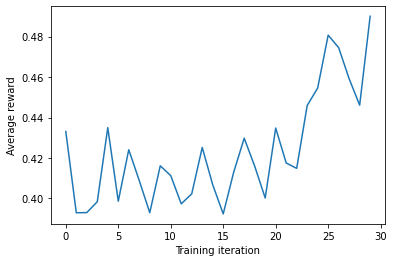

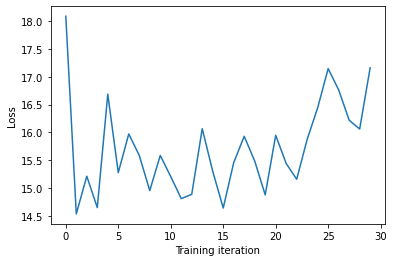

Generating molecules...: 100%|████████████████| 200/200 [00:04<00:00, 49.33it/s]
[12:26:07] Explicit valence for atom # 53 Br, 3, is greater than permitted


Setting molecule featurization parameters to default.
Loading data


199it [00:00, 106340.49it/s]
100%|█████████████████████████████████████| 199/199 [00:00<00:00, 237390.93it/s]


Validating SMILES
Test size = 199


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.93it/s]

Saving predictions to None
Elapsed time = 0:00:01
199
Percentage of predictions within drug-like region: 0.0
Proportion of valid SMILES: 0.995


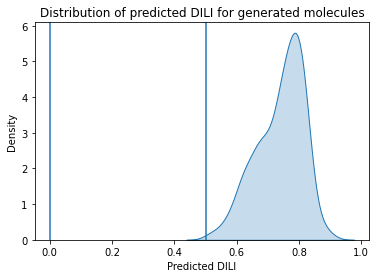

Sample trajectories:
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)O[NH1]S[C@H1]
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)O\COC=[C@@H1]OC(C)C[C@H1]CCCCC
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)O
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)OC(C)CC=O
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C56)F)F)OSN6NCCCSCCNC=N


Policy gradient...:   0%|                                | 0/15 [00:00<?, ?it/s]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14614.30it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13400.33it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13066.37it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.15it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12748.64it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15033.35it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13706.88it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16256.99it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7182.03it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.98it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 8004.40it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4306.27it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.38it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.27it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13842.59it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14413.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13981.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15534.46it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.76it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15887.52it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15033.35it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.28it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.21it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10255.02it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13751.82it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:   7%|█▌                      | 1/15 [00:07<01:45,  7.54s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14614.30it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16256.99it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13530.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13797.05it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13751.82it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 9962.72it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13934.56it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.22it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12985.46it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13443.28it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.33it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.16it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9868.95it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6831.11it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.15it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12483.05it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13617.87it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12157.40it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.26it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 6875.91it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  13%|███▏                    | 2/15 [00:14<01:37,  7.47s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15033.35it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11397.57it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14820.86it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.06it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14217.98it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13066.37it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.06it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10782.27it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.93it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11586.48it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.81it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12710.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.90it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9597.95it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.95it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 2732.45it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5017.11it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.90it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12336.19it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13231.24it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  20%|████▊                   | 3/15 [00:22<01:31,  7.59s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11683.30it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5890.88it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.93it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15141.89it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.85it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14563.56it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.90it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 6141.00it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.73it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]
[12:26:34] Explicit valence for atom # 52 Br, 4, is greater than permitted


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



0it [00:00, ?it/s]

0it [00:00, ?it/s]


Validating SMILES
Test size = 0
Elapsed time = 0:00:00
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15307.68it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15307.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.22it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14364.05it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 1518.57it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4373.62it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.33it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11096.04it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4359.98it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.97it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12446.01it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4911.36it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.08it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11949.58it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.98it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  27%|██████▍                 | 4/15 [00:30<01:24,  7.66s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13751.82it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11848.32it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13797.05it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12372.58it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2644.58it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10330.80it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13107.20it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.06it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15477.14it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.67it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12228.29it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14665.40it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13443.28it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.25it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.20it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7973.96it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4315.13it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.19it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14463.12it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16513.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.31it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.27it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14614.30it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  33%|████████                | 5/15 [00:38<01:16,  7.62s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13025.79it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14122.24it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13981.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16008.79it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.19it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4544.21it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6423.13it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.18it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.23it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12595.51it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5629.94it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.69it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4021.38it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.80it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12787.51it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15307.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11715.93it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14614.30it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13751.82it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 11949.58it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.23it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13662.23it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.36it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.24it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  40%|█████████▌              | 6/15 [00:45<01:08,  7.62s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14463.12it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17697.49it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.31it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.35it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11881.88it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14463.12it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.15it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15252.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.34it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.19it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13273.11it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.06it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 5190.97it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8289.14it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.75it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14768.68it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11428.62it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15534.46it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9177.91it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15033.35it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.25it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10305.42it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15307.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  47%|███████████▏            | 7/15 [00:53<01:00,  7.56s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9510.89it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.08it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14413.42it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17697.49it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13315.25it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13189.64it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13981.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.15it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13981.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14563.56it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.97it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14122.24it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 10810.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14513.16it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 8848.74it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.19it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11983.73it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5059.47it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.76it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12945.38it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  53%|████████████▊           | 8/15 [01:00<00:52,  7.54s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13797.05it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5041.23it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.89it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4181.76it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2090.88it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.89it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14122.24it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.22it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 16194.22it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.08it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.21it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11881.88it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12409.18it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13751.82it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.08it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11275.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.14it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11949.58it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13617.87it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14074.85it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15947.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.03it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14563.56it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15947.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.03it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  60%|██████████████▍         | 9/15 [01:08<00:45,  7.55s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15947.92it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.19it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15141.89it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9383.23it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 10591.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.93it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12372.58it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15947.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.77it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13443.28it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13751.82it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16008.79it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11683.30it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9576.04it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13107.20it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.16it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13662.23it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.18it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  67%|███████████████▎       | 10/15 [01:15<00:37,  7.54s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13573.80it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13797.05it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4934.48it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.17it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9157.87it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.22it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15252.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16777.22it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.18it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14027.77it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15363.75it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.82it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12865.96it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.95it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13148.29it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14266.34it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13486.51it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.66it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  73%|████████████████▊      | 11/15 [01:23<00:30,  7.50s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14513.16it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12787.51it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.18it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13486.51it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.97it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13573.80it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.17it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7219.11it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4144.57it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.93it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12945.38it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14614.30it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.18it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.19it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13617.87it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.14it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14266.34it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.84it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12748.64it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.93it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14463.12it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15947.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  80%|██████████████████▍    | 12/15 [01:30<00:22,  7.49s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13231.24it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14364.05it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.30it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13273.11it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.71it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14315.03it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.08it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14027.77it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14217.98it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.10it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7626.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13189.64it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.63it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12787.51it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16844.59it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.14it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13357.66it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13107.20it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10618.49it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 11184.81it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  87%|███████████████████▉   | 13/15 [01:38<00:15,  7.59s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11397.57it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2993.79it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13530.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14463.12it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16256.99it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9000.65it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2957.90it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.21it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.89it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14873.42it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17050.02it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.38it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.28it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13273.11it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.96it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12945.38it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13751.82it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13107.20it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.20it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15534.46it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.25it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.24it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13617.87it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  93%|█████████████████████▍ | 14/15 [01:45<00:07,  7.56s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12985.46it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15477.14it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 8490.49it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.15it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14463.12it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.27it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.20it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12865.96it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.15it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10591.68it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13273.11it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.98it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11618.57it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 9554.22it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14169.95it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.23it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13400.33it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.96it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13315.25it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.08it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12446.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...: 100%|███████████████████████| 15/15 [01:53<00:00,  7.56s/it]


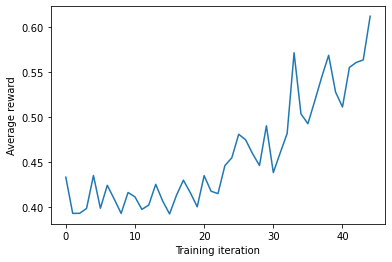

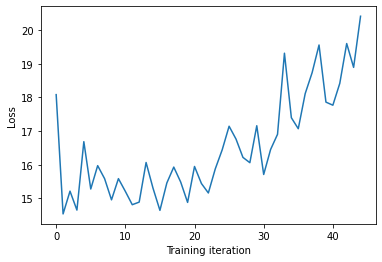

Generating molecules...: 100%|████████████████| 200/200 [00:04<00:00, 48.00it/s]


Setting molecule featurization parameters to default.
Loading data


200it [00:00, 220927.26it/s]
100%|█████████████████████████████████████| 200/200 [00:00<00:00, 253279.23it/s]


Validating SMILES
Test size = 200


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.99it/s]

Saving predictions to None
Elapsed time = 0:00:01
200
Percentage of predictions within drug-like region: 0.0
Proportion of valid SMILES: 1.0


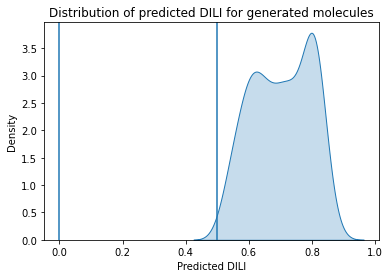

Sample trajectories:
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)O[C@@][O-1]
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)OC=CC=CC(C)CC#C[C@]CC=CCCC
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)OC=CC=CC=C(C)CC(=O)CCC(C)CCC
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)OI
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)OCCCCCCC=C(CCN)CCCCCC


Policy gradient...:   0%|                                | 0/15 [00:00<?, ?it/s]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13797.05it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.76it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14665.40it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13107.20it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15307.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12985.46it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17050.02it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13357.66it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5171.77it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13273.11it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16513.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14315.03it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7884.03it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8490.49it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.25it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14074.85it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13273.11it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:   7%|█▌                      | 1/15 [00:07<01:47,  7.71s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14364.05it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15534.46it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.14it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11586.48it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13148.29it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.95it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11522.81it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14169.95it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.82it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10538.45it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14364.05it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.21it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11949.58it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.14it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14217.98it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14873.42it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8665.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13148.29it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.29it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.23it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 8208.03it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2894.62it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.21it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  13%|███▏                    | 2/15 [00:15<01:39,  7.65s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9137.92it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.16it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13273.11it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12409.18it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7025.63it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.16it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14169.95it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.20it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13357.66it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15087.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11748.75it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12157.40it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9845.78it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11554.56it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12748.64it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.84it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.64it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12409.18it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  20%|████▊                   | 3/15 [00:23<01:32,  7.70s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13231.24it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12122.27it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.83it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12787.51it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.77it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14820.86it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14614.30it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15947.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.77it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13315.25it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.81it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13934.56it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7025.63it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.83it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12787.51it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13751.82it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.68it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.71it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11848.32it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15252.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.59it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10922.67it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.96it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12985.46it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15947.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.44it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.65it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  27%|██████▍                 | 4/15 [00:31<01:26,  7.89s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12633.45it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.67it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12905.55it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.95it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13273.11it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4152.78it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.95it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13357.66it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15768.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.06it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14027.77it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2117.27it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.85it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10330.80it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10305.42it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14413.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11554.56it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13617.87it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12052.60it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11066.77it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.84it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  33%|████████                | 5/15 [00:39<01:19,  7.95s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11781.75it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5570.12it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.85it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.77it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10672.53it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5197.40it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.80it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10280.16it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.93it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.77it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12748.64it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.70it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10356.31it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4865.78it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7108.99it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.96it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 3765.08it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4578.93it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.62it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.66it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12671.61it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.85it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12985.46it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13981.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13273.11it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13617.87it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.78it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  40%|█████████▌              | 6/15 [00:47<01:12,  8.02s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9554.22it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11428.62it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.78it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13400.33it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15307.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 2229.83it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.78it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14563.56it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12633.45it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13443.28it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.82it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11915.64it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.89it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13066.37it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4297.44it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12372.58it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6732.43it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11491.24it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15709.00it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.89it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  47%|███████████▏            | 7/15 [00:55<01:03,  7.97s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11983.73it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4981.36it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13662.23it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15477.14it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13273.11it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15033.35it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10922.67it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 11428.62it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.89it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13315.25it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.03it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13189.64it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.71it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12985.46it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14364.05it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14315.03it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.23it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10180.35it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  53%|████████████▊           | 8/15 [01:03<00:55,  7.93s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13443.28it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.13it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14266.34it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.08it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12228.29it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13617.87it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13797.05it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13751.82it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.19it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13751.82it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.68it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.65it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14315.03it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14716.86it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.89it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13486.51it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15477.14it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12865.96it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13530.01it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  60%|██████████████▍         | 9/15 [01:10<00:47,  7.89s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14716.86it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14413.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.03it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9039.45it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.96it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10205.12it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.82it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12985.46it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13981.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.72it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.68it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10951.19it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13107.20it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12520.31it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7219.11it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.93it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11848.32it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13751.82it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.90it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.65it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12905.55it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.82it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.72it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11335.96it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13751.82it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.81it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.77it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  67%|███████████████▎       | 10/15 [01:19<00:39,  7.94s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 3269.14it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]
[12:29:27] Explicit valence for atom # 52 Br, 4, is greater than permitted


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



0it [00:00, ?it/s]

0it [00:00, ?it/s]


Validating SMILES
Test size = 0
Elapsed time = 0:00:00
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13231.24it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4755.45it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.77it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 1990.65it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 9137.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11781.75it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.64it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.68it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12300.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.75it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.70it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11881.88it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13797.05it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.95it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14074.85it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4096.00it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.06it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12787.51it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5753.50it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.56it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.72it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13148.29it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14074.85it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15947.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.64it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.75it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  73%|████████████████▊      | 11/15 [01:27<00:31,  8.00s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12557.80it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12905.55it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.77it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.69it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11814.94it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13273.11it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11848.32it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.79it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12300.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.77it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13751.82it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.97it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11848.32it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13189.64it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4798.97it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.78it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 6492.73it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7958.83it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.03it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13025.79it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.65it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.70it/s]
[12:29:41] Explicit valence for atom # 51 Br, 4, is greater than permitted


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



0it [00:00, ?it/s]

0it [00:00, ?it/s]


Validating SMILES
Test size = 0
Elapsed time = 0:00:00
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 1576.81it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5090.17it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.50it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.68it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  80%|██████████████████▍    | 12/15 [01:35<00:24,  8.07s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14513.16it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12018.06it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15307.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.81it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14122.24it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.54it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.66it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10922.67it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12122.27it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.70it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.69it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13934.56it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4462.03it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.69it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 1799.36it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3754.97it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.01it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4490.69it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5309.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15252.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16513.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.02it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15087.42it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14563.56it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.78it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12157.40it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.97it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  87%|███████████████████▉   | 13/15 [01:43<00:16,  8.04s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13148.29it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.31it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11683.30it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.06it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13530.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13486.51it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1253.15it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4665.52it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4999.17it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4899.89it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5084.00it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7449.92it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7598.38it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.51it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.70it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 6482.70it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 9058.97it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 16008.79it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14364.05it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  93%|█████████████████████▍ | 14/15 [01:51<00:08,  8.04s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12264.05it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.81it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11949.58it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.80it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 8019.70it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4271.19it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.61it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 8683.86it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 9058.97it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.84it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14266.34it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 8490.49it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3097.71it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12865.96it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.60it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14463.12it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4092.00it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13148.29it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13231.24it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...: 100%|███████████████████████| 15/15 [01:59<00:00,  7.96s/it]


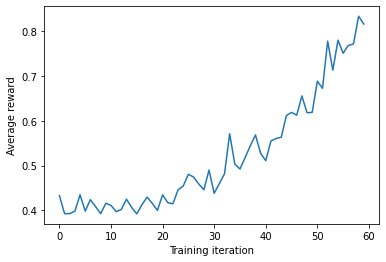

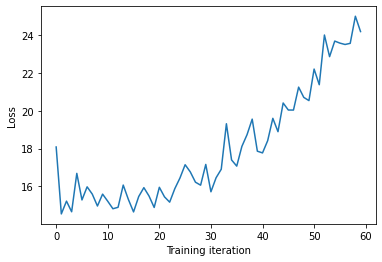

Generating molecules...: 100%|████████████████| 200/200 [00:03<00:00, 50.07it/s]
[12:30:11] Explicit valence for atom # 54 Br, 3, is greater than permitted
[12:30:11] Explicit valence for atom # 53 Br, 3, is greater than permitted


Setting molecule featurization parameters to default.
Loading data


198it [00:00, 233213.20it/s]
100%|█████████████████████████████████████| 198/198 [00:00<00:00, 250217.59it/s]


Validating SMILES
Test size = 198


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.95it/s]

Saving predictions to None
Elapsed time = 0:00:01
198
Percentage of predictions within drug-like region: 0.020202020202020204
Proportion of valid SMILES: 0.99


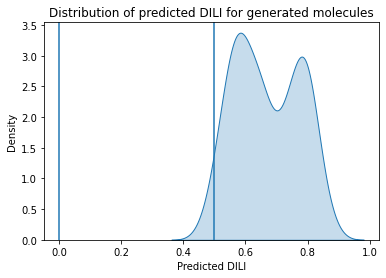

Sample trajectories:
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)OCCCCCC[C@@H1](C)C(C6)[C@H1]=NCC=C6
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)OCCCCCNCCCCCNCC=CC
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)OCCCC(C)CCNCCCCCCC
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)OCCCCCOCCCCNOCCCC#N
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)OCCCl


Policy gradient...:   0%|                                | 0/15 [00:00<?, ?it/s]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4609.13it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6978.88it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4068.19it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2361.66it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12748.64it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.65it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14563.56it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15033.35it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.17it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14074.85it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2122.62it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.81it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12865.96it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15307.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.73it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13189.64it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5599.87it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.59it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7928.74it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2532.79it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.06it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7667.83it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.26it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13025.79it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5511.57it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:   7%|█▌                      | 1/15 [00:07<01:50,  7.89s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10106.76it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14074.85it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15947.92it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.73it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.89it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12300.01it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5047.30it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.96it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.07it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14413.42it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.70it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11522.81it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4798.97it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.85it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10754.63it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4712.70it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 5785.25it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2853.27it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.97it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13617.87it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13025.79it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13617.87it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14413.42it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16256.99it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.89it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  13%|███▏                    | 2/15 [00:15<01:42,  7.91s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9709.04it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4686.37it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.55it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.67it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11949.58it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.14it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13888.42it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16844.59it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.82it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14563.56it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5440.08it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12865.96it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.09it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 15033.35it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14122.24it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6864.65it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.82it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9404.27it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.68it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.75it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12985.46it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14820.86it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.80it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.77it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 3751.61it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  20%|████▊                   | 3/15 [00:23<01:35,  7.98s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11491.24it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.75it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.75it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14614.30it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.89it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13231.24it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3194.44it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.71it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.71it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 5412.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4539.29it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4462.03it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.76it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.74it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 8128.50it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13934.56it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4040.76it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.97it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13888.42it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15534.46it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.90it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13888.42it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1055.17it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.95it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14217.98it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.78it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.68it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  27%|██████▍                 | 4/15 [00:32<01:28,  8.05s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14217.98it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.73it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 1583.35it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4476.31it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11983.73it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6052.39it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12446.01it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5035.18it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.76it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.71it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11155.06it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4152.78it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.18it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.13it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13486.51it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.20it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13443.28it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15087.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12520.31it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14820.86it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.63it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.71it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13189.64it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.77it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10155.70it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  33%|████████                | 5/15 [00:40<01:22,  8.21s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13573.80it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.78it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4433.73it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4490.69it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.77it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4573.94it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.64it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.63it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10330.80it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.89it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.77it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 2874.78it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4271.19it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.73it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14665.40it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.75it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]
[12:30:57] Explicit valence for atom # 51 Br, 3, is greater than permitted


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



0it [00:00, ?it/s]

0it [00:00, ?it/s]


Validating SMILES
Test size = 0
Elapsed time = 0:00:00
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 2534.32it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4161.02it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.59it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.71it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14169.95it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.63it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.62it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14027.77it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4821.04it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.93it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13981.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.81it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  40%|█████████▌              | 6/15 [00:48<01:14,  8.28s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13231.24it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.82it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.77it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14413.42it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.76it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.74it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 2744.96it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4665.52it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.79it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.64it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 1648.70it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2517.59it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.66it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.74it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14169.95it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6563.86it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 1831.57it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5146.39it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.60it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.67it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9686.61it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 10591.68it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.69it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 8035.07it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4088.02it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.78it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.68it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10894.30it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12557.80it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.67it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14217.98it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.88it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  47%|███████████▏            | 7/15 [00:57<01:07,  8.39s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 6297.75it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5011.12it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.79it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.72it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14614.30it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6462.72it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.79it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 5053.38it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.00it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.66it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 9986.44it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.68it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.65it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12748.64it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5533.38it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.97it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 1866.62it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5140.08it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.79it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13486.51it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4202.71it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.83it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4262.50it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3266.59it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.75it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.71it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13706.88it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.98it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14027.77it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  53%|████████████▊           | 8/15 [01:05<00:58,  8.38s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14122.24it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11814.94it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.54it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.65it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12787.51it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2432.89it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.49it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.63it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11915.64it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13273.11it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.84it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4048.56it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4993.22it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.77it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 1700.16it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.93it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13107.20it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5504.34it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.84it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13617.87it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 12409.18it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.84it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.61it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13025.79it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5197.40it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14364.05it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.91it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.66it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  60%|██████████████▍         | 9/15 [01:14<00:50,  8.43s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11554.56it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4052.47it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.66it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.70it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 6636.56it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12985.46it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.94it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14563.56it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15033.35it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.82it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4675.92it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5475.59it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 6374.32it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.80it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10058.28it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2501.08it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.68it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13751.82it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15477.14it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.93it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4519.72it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.78it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14315.03it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5302.53it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.84it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  67%|███████████████▎       | 10/15 [01:22<00:41,  8.37s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12905.55it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.90it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13189.64it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.78it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.69it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10407.70it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5329.48it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.75it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.77it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10894.30it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5329.48it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.78it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13443.28it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5833.52it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.43it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.61it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 5745.62it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6700.17it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.71it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.74it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12052.60it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.59it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.63it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14266.34it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4419.71it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.55it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.58it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14074.85it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15477.14it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.90it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13617.87it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5660.33it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.90it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  73%|████████████████▊      | 11/15 [01:31<00:33,  8.38s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 5675.65it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2753.98it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.84it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.58it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7884.03it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.05it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 5349.88it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2637.93it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.72it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4712.70it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4750.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.85it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.77it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11715.93it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.74it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4332.96it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2158.67it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.76it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.74it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 3368.92it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3880.02it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.98it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7796.10it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.65it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.71it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 3382.50it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.76it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14614.30it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2026.23it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.80it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  80%|██████████████████▍    | 12/15 [01:39<00:25,  8.38s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4686.37it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.78it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10407.70it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5309.25it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.71it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.72it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 6732.43it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2113.00it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.80it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12595.51it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6482.70it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.90it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13888.42it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.67it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.77it/s]
[12:31:55] Explicit valence for atom # 52 Br, 3, is greater than permitted


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



0it [00:00, ?it/s]

0it [00:00, ?it/s]


Validating SMILES
Test size = 0
Elapsed time = 0:00:00
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 14979.66it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3155.98it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.47it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.66it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 8289.14it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5223.29it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.47it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.51it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13662.23it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6355.01it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.75it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13486.51it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.67it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13025.79it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.86it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.75it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  87%|███████████████████▉   | 13/15 [01:47<00:16,  8.42s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 5419.00it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4419.71it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.79it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12336.19it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4096.00it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.63it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.70it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12710.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.66it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4771.68it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12409.18it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2074.33it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.03it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4198.50it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5511.57it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.62it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 3823.43it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.79it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11586.48it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 15033.35it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.72it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 11881.88it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5146.39it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.64it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.75it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4297.44it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2121.55it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.77it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...:  93%|█████████████████████▍ | 14/15 [01:56<00:08,  8.41s/it]

Setting molecule featurization parameters to default.
Loading data



1it [00:00, 13751.82it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5454.23it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.70it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.63it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7810.62it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4198.50it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.10it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 8525.01it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.17it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10205.12it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14563.56it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.19it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.21it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 4315.13it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.19it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.18it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10485.76it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4112.06it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.26it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10837.99it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.10it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.19it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 10810.06it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 13400.33it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.18it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 12483.05it/s]

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 14169.95it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.10it/s]


Saving predictions to None
Elapsed time = 0:00:01
Setting molecule featurization parameters to default.
Loading data



1it [00:00, 7653.84it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2600.31it/s]


Validating SMILES
Test size = 1



  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]

                                                                                
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.17it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]

                                                                                
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.21it/s]


Saving predictions to None
Elapsed time = 0:00:01


Policy gradient...: 100%|███████████████████████| 15/15 [02:06<00:00,  8.43s/it]


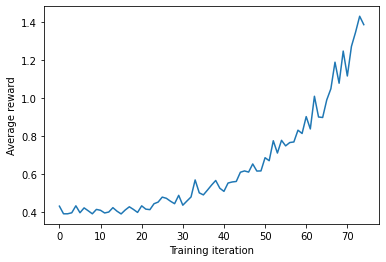

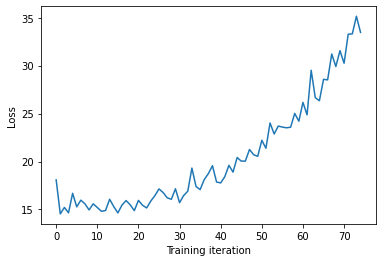

Generating molecules...: 100%|████████████████| 200/200 [00:04<00:00, 45.05it/s]
[12:32:23] Explicit valence for atom # 52 Br, 3, is greater than permitted


Setting molecule featurization parameters to default.
Loading data


199it [00:00, 116965.60it/s]
100%|█████████████████████████████████████| 199/199 [00:00<00:00, 214677.60it/s]


Validating SMILES
Test size = 199


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s]


Saving predictions to None
Elapsed time = 0:00:01
199
Percentage of predictions within drug-like region: 0.22613065326633167
Proportion of valid SMILES: 0.995


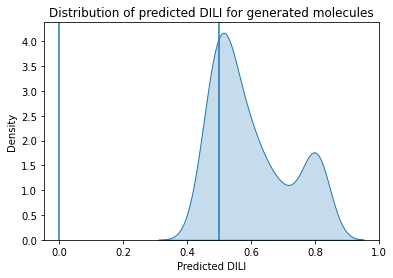

Sample trajectories:
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)O/NCCCCCCCCCCC(C)(C)CCC
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)OCC=O
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)OC(C)CCCCCCCCCCCCCCCCCCCC
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)O/C[P+1]/N\[C@@H1]\S
CC(C1=NC(=CS1)C2=CC=C(C=C2)C#N)C(CN3C=[N+1](C=N3)C(C)OC(=O)N(C)C4=C(C=CC=N4)COC(=O)CNC)(C5=C(C=CC(=C5)F)F)OCCSCCCCCC=CC=CCN=NCCCCCC


In [145]:
for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_logp.policy_gradient(gen_data)
        rewards.append(simple_moving_average(rewards, cur_reward)) 
        rl_losses.append(simple_moving_average(rl_losses, cur_loss))
    
    plt.plot(rewards)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
        
    smiles_cur, prediction_cur = estimate_and_update(RL_logp.generator, 
                                                     my_predictor, drug, 
                                                     n_to_generate)
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)
    print(str(i+1) + " out of " + str(n_iterations) + " complete!")

Generating molecules...: 100%|██████████████| 1000/1000 [00:19<00:00, 51.00it/s]
[12:32:47] Explicit valence for atom # 59 Br, 3, is greater than permitted
[12:32:47] Explicit valence for atom # 51 Br, 3, is greater than permitted
[12:32:47] Explicit valence for atom # 51 Br, 3, is greater than permitted
[12:32:47] Explicit valence for atom # 53 Br, 3, is greater than permitted
[12:32:47] Explicit valence for atom # 53 Br, 3, is greater than permitted
[12:32:47] Explicit valence for atom # 60 Br, 4, is greater than permitted
[12:32:47] Explicit valence for atom # 53 Br, 3, is greater than permitted
[12:32:47] Explicit valence for atom # 54 Br, 3, is greater than permitted
[12:32:47] Explicit valence for atom # 51 Br, 5, is greater than permitted


Setting molecule featurization parameters to default.
Loading data


991it [00:00, 283607.76it/s]
100%|█████████████████████████████████████| 991/991 [00:00<00:00, 262757.14it/s]

Validating SMILES


Test size = 991


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/it]


Saving predictions to None
Elapsed time = 0:00:03
991
Percentage of predictions within drug-like region: 0.24520686175580222
Proportion of valid SMILES: 0.991


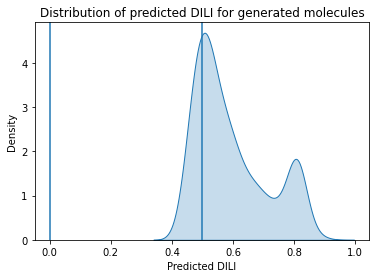

In [146]:
smiles_biased, prediction_biased = estimate_and_update(RL_logp.generator, 
                                                       my_predictor,
                                                       drug,
                                                       n_to_generate=1000)

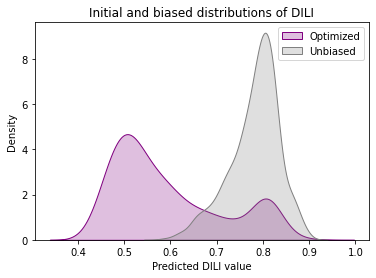

In [147]:
sns.kdeplot(prediction_biased, label='Optimized', shade=True, color='purple')
sns.kdeplot(prediction_unbiased, label='Unbiased', shade=True, color='grey')
plt.xlabel('Similarity value')
plt.title('Initial and biased distributions of Similarity')
plt.legend()
plt.show()

### Drawing random molecules

Now we will draw some random compounds from the biased library:

In [148]:
mol, pred, invalid = my_predictor.predictFromSmiles(smiles_biased)

Setting molecule featurization parameters to default.
Loading data


991it [00:00, 164498.78it/s]
100%|█████████████████████████████████████| 991/991 [00:00<00:00, 255914.00it/s]


Validating SMILES
Test size = 991


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.24s/it]

Saving predictions to None
Elapsed time = 0:00:03


In [149]:
goodDrugsTuple = []
for i in range(len(mol)):
    if pred[i] < 0.5:
        goodDrugsTuple.append((mol[i],pred[i]))

In [150]:
import pandas as pd
goodDrugs = pd.DataFrame(goodDrugsTuple,columns = ['Drug','Pred'])

In [151]:
goodDrugsUniquified = goodDrugs.drop_duplicates()

In [ ]:
goodDrugsUniquified

In [152]:
print('Uniqueness is ' + "%.2f" % (len(goodDrugsUniquified)/len(goodDrugs)))

Uniqueness is 0.98


In [153]:
goodBiasedDrugsUnique = goodDrugsUniquified['Drug'].tolist()
goodBiasedPredsUnique = goodDrugsUniquified['Pred'].tolist()

In [154]:
from rdkit.Chem import Draw

In [155]:
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

In [156]:
generated_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in goodBiasedDrugsUnique] #could use just smiles_biased 

In [157]:
sanitized_gen_mols = [generated_mols[i] for i in np.where(np.array(generated_mols) != None)[0]]

In [158]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = ['DILI = ' + str(goodBiasedPredsUnique[i]) for i in ind] #or prediction_biased if all good and bad

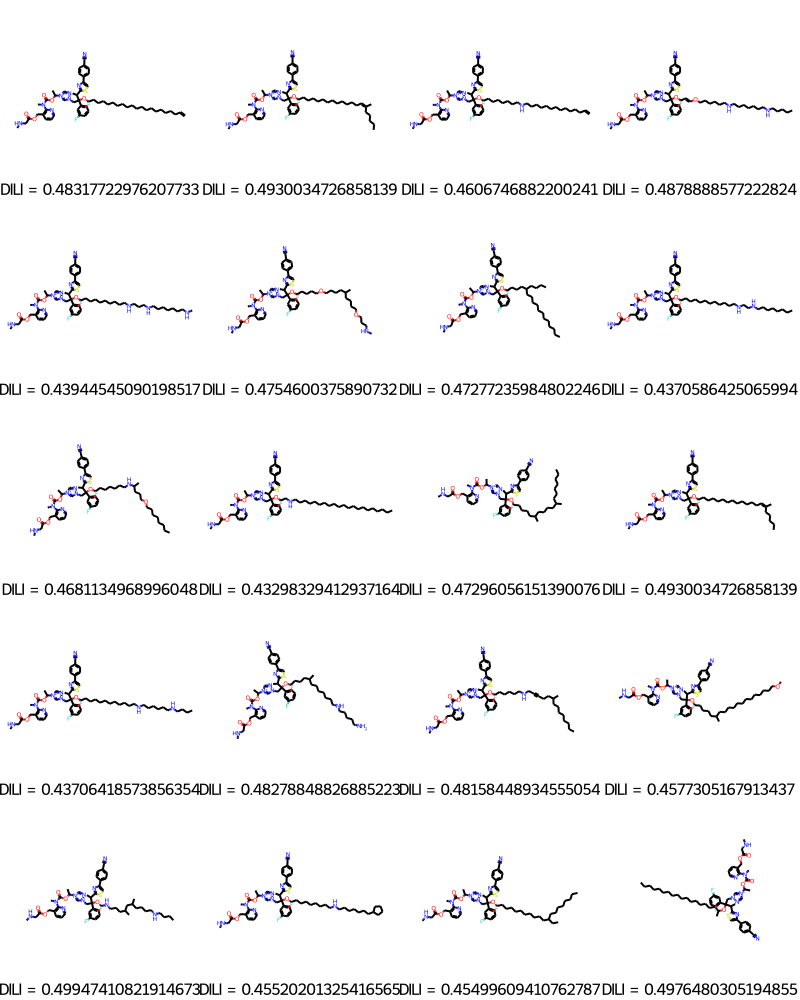

In [159]:
Draw.MolsToGridImage(mols_to_draw, molsPerRow=4, 
                     subImgSize=(200,200), legends=legends)